In [ ]:
"""
CONVOLUTION ENCODER-DECODER FOR ART 

 Art images given in npy arrays


Modigliani_paintings.npy
Abstractblue.npy
NEURON128x128.npy

#image values are already normalized in [0 1]

libraries: 

!pip install opencv-python tensorflow keras numpy scikit-learn os torch torchvision torchaudio pillow


"""

In [ ]:

"""
load data set (IMAGE SIZE 128x128)

Modigliani_paintings.npy
AbstractPaintings_Dataset.npy

#image values are already normalized in [0 1]

"""

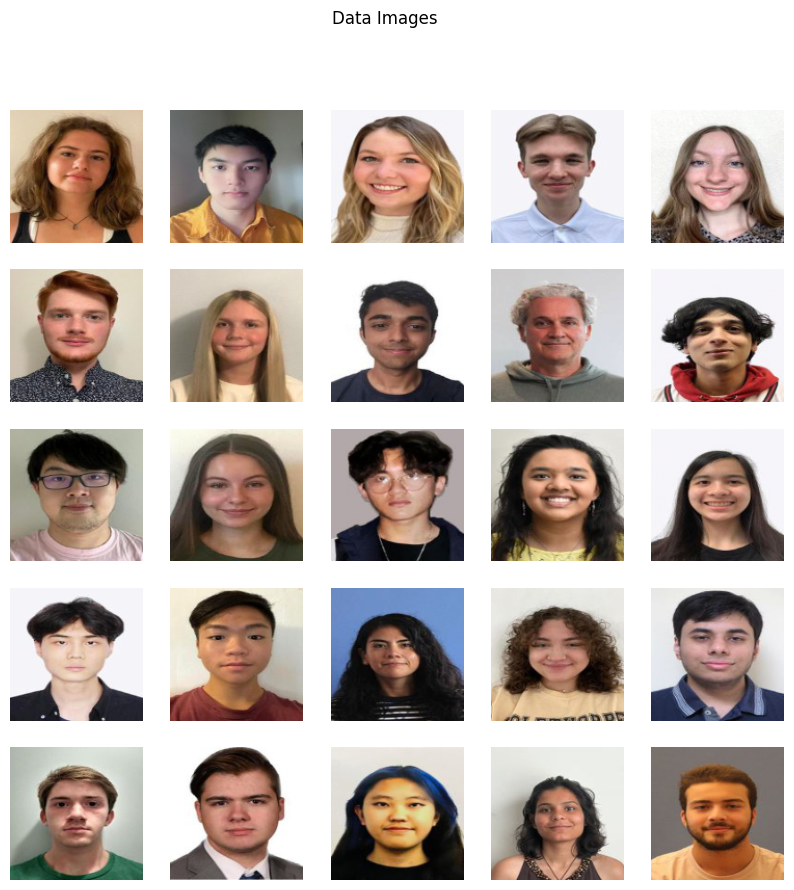

data loaded


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Piet_Mondrian128x128.npy
#Gustav_Klimt128x128.npy
#Henri_Matisse128x128.npy 
#Jackson_Pollock128x128.npy 
#Pablo_Picasso128x128.npy


#data already normalized by 255, in the range [0 1]

#dataset shape: (num images, size, size, channels)
#data = np.load("NEURON128x128.npy")

data0 = np.load("Piet_Mondrian128x128.npy")
data1 = np.load("STUDENT_PHOTOS128x128.npy")
data3 = np.load("Abstractblue.npy")
data4 = np.load("Frida_Kahlo128x128.npy")
data5 = np.load("Andy_Warhol64x64.npy")  

data6 = np.load("Piet_Mondrian_geometric128x128.npy")
data7 = np.load("Jackson_Pollock128x128.npy")
data8 = np.load("Pablo_Picasso_faces128x128.npy")
data9 = np.load("FinalLightPaintingData128x128.npy")
data10 = np.load("Tunnel128x128.npy")
data11 = np.load("Butterfly128x128.npy")
data12 = np.load("Gabbiano_portrait64x64.npy")
data13 = np.load("Gabbiano_portrait128x128.npy")
data14 = np.load("STUDENT_PHOTOS128x128.npy")


# Step 1: Define the original filename and new filename
filename = "STUDENT_PHOTOS128x128"  # You can replace this with your desired name

# Step 2: Load the corresponding array from the original file
data = np.load(filename + ".npy")


num_samples, img_size, canc, channels = data.shape

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = data[i]
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
    ax.imshow(img)
    ax.axis("off")
    plt.suptitle("Data Images")
    
plt.savefig("AE" + filename + ".png", format="png", dpi=300)  # Save as PNG
plt.savefig("AE" + filename + ".eps", format="eps")  # Save as PDF
plt.savefig("AE" + filename + ".pdf", format="pdf")  # Save as PDF
plt.savefig("AE" + filename + ".tiff", format="tiff", dpi=300)  # Save as TIFF

plt.show()


data.shape

print("data loaded")

In [2]:
"""  
save training data in a numpy array that
     will be used by the main code

""" 

# choose filename to save the image data
np.save("training_images.npy", data)

print("training data saved")

training data saved


In [ ]:
"""
ENCODER ARCHITECTURE


Input Image: (batch_size, 3, 128, 128)
After 1st Conv Layer: (batch_size, 64, 64, 64)
After 2nd Conv Layer: (batch_size, 32, 32, 32)
After 3rd Conv Layer: (batch_size, 16, 16, 16) (Latent space representation)
After 1st Transpose Conv Layer: (batch_size, 32, 32, 32)
After 2nd Transpose Conv Layer: (batch_size, 64, 64, 64)
After 3rd Transpose Conv Layer: (batch_size, 3, 128, 128) (Reconstructed image)

"""


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("using device: " + str(device))


# --- 1. Define Dataset ---
class ArtDataset(Dataset):
    def __init__(self, images):
        self.images = images.astype(np.float32) #/ 255.0  # Normalize to [0,1]
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # Shape: (img_size, img_size, channels)
        img = self.transform(img)  # Convert to (C, H, W)
        return img

# --- 2. Define Convolutional Autoencoder ---
class ConvAutoencoder(nn.Module):
    def __init__(self, channels=3):
        super(ConvAutoencoder, self).__init__()
        # Encoder: Compress input into a smaller representation
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, stride=2, padding=1),   # Output: 64 channels
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),        # Output: 32 channels
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),        # Output: 16 channels (latent space)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*16*16, 128)  # Add bottleneck!
        )
        
        
        
        # Decoder: Expand latent space representation back to original input size
        self.decoder = nn.Sequential(
            nn.Linear(128, 16*16*16),
            nn.Unflatten(1, (16, 16, 16)),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # Increase to 32 channels
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # Increase to 64 channels
            nn.ReLU(),
            nn.ConvTranspose2d(64, channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output 3 channels (RGB)
            nn.Sigmoid()  # Sigmoid to scale outputs to [0, 1] for RGB images
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))
        #x = self.encoder(x)
        #x = self.decoder(x)
        #return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

# --- 3. Training Function ---
def train_autoencoder(model, dataloader, epochs=100, lr=0.001):
    criterion = nn.MSELoss()  #n.L1Loss()  SmoothL1Loss()  BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) #AdamW for sparsity 
    alpha = 0.001
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch in dataloader:
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch) + alpha * torch.mean(torch.abs(model.encode(batch))) # add L1 norm for sparsity
            #loss = criterion(outputs, batch) + alpha * torch.mean(torch.linalg.vector_norm(model.encode(batch),ord=2))
            #loss = 0.5 * nn.MSELoss()(output, target) + 0.5 * nn.L1Loss()(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"\rEpoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}", end="", flush=True)

# --- 4. Load and Process Data ---
def load_images(image_array, batch_size=32):
    dataset = ArtDataset(image_array)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# --- 5. Testing Function (Visualizing Input-Output) ---
def test_autoencoder(model, dataloader, num_images):
    model.eval()
    images = next(iter(dataloader))[:num_images]  # Get first batch
    
    with torch.no_grad():
        reconstructed = model(images)

    images = images.numpy().transpose(0, 2, 3, 1)
    reconstructed = reconstructed.numpy().transpose(0, 2, 3, 1)
    
    fig, axes = plt.subplots(2, num_images, figsize=(12, 5))
    for i in range(num_images):
        axes[0, i].imshow(images[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i])
        axes[1, i].axis('off')

    axes[0, 0].set_title("Original")
    axes[1, 0].set_title("Reconstructed")
    plt.show()

# --- Latent Space Interpolation ---
def interpolate_images(autoencoder, dataloader, steps=10):
    autoencoder.eval()  # Set model to evaluation mode
    
    images = next(iter(dataloader))[:2]  # Take two images
    with torch.no_grad():
        z1 = autoencoder.encoder(images[0].unsqueeze(0))  # Encode first image
        z2 = autoencoder.encoder(images[1].unsqueeze(0))  # Encode second image
    
    interpolated_images = []
    for alpha in np.linspace(0, 1, steps):
        z_interp = (1 - alpha) * z1 + alpha * z2  # Linear interpolation
        img_interp = autoencoder.decoder(z_interp).squeeze(0).permute(1, 2, 0).detach().numpy()
        interpolated_images.append(img_interp)

    # Plot the interpolation results
    fig, axes = plt.subplots(1, steps, figsize=(15, 5))
    for i in range(steps):
        axes[i].imshow(interpolated_images[i])
        axes[i].axis('off')

    plt.show()



# --- 6. Main Execution ---
if __name__ == "__main__":
    # Load images from file
    images_np = np.load('training_images.npy')
    dataloader = load_images(images_np, batch_size=16)
    
    autoencoder = ConvAutoencoder(channels=images_np.shape[-1])
    
    # Train model
    train_autoencoder(autoencoder, dataloader, epochs=2000, lr=0.005)
    
    images_np = np.load("VanGogh.npy")
    dataloader = load_images(images_np, batch_size=32)
    # Test model
    test_autoencoder(autoencoder, dataloader, num_images=10)

    images_np = np.load("Gabbiano_art128x128.npy")
    dataloader = load_images(images_np, batch_size=32)
    # Test model
    test_autoencoder(autoencoder, dataloader, num_images=10)

    images_np = np.load("Modigliani_paintings.npy")
    dataloader = load_images(images_np, batch_size=32)
    # Test model
    test_autoencoder(autoencoder, dataloader, num_images=10)
    
    
    images_np = np.load("STUDENT_PHOTOS128x128.npy")
    dataloader = load_images(images_np, batch_size=28)
    # Test model
    test_autoencoder(autoencoder, dataloader, num_images=10)


    # Interpolation
    interpolate_images(autoencoder, dataloader)
    


using device: cuda
Epoch 27/2000, Loss: 0.036305

KeyboardInterrupt: 

In [ ]:
"""
to save a trained autoencoder
"""

# Save the model after training for later use
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

print("trained model saved")

In [ ]:
"""
to load a saved trained autoencoder
"""

autoencoder = ConvAutoencoder(channels=3)  # Initialize the model
autoencoder.load_state_dict(torch.load('autoencoder.pth'))  # Load saved weights
autoencoder.eval()  # Set the model to evaluation mode for testing


print("trained model loaded")

In [ ]:

"""
MAKING ART WITH THE AUTOENCODER
1. Latent Space Average
This smoothly blends between two or more images images by averaging their latent representations.
""""



In [ ]:

def generate_weighted_image(autoencoder, images, weights):
    # Ensure the model is in evaluation mode
    autoencoder.eval()

    # Move images to the correct device
    images = images.to(next(autoencoder.parameters()).device)

    # Encode the images to get their latent vectors
    with torch.no_grad():
        latent_vectors = [autoencoder.encoder(img.unsqueeze(0)) for img in images]
    
    # Compute the weighted average of the latent vectors
    weighted_latent = sum(weight * latent for weight, latent in zip(weights, latent_vectors))
    
    # Decode the weighted average latent vector to get the new image
    with torch.no_grad():
        generated_image = autoencoder.decoder(weighted_latent).squeeze(0).cpu().numpy().transpose(1, 2, 0)

    return generated_image

# Testing function: Plot original images and the generated image
def test_weighted_average(autoencoder, dataloader, weights=[0.5, 0.5], num_images=2):
    autoencoder.eval()
    
    # Get the first batch of images
    images = next(iter(dataloader))[:num_images]
    
    # Generate a weighted average image
    generated_image = generate_weighted_image(autoencoder, images, weights)
    
    # Convert images to numpy format for visualization
    images_np = images.numpy().transpose(0, 2, 3, 1)
    
    # Plot original images and generated image
    fig, axes = plt.subplots(1, num_images + 1, figsize=(15, 5))
    
    for i in range(num_images):
        axes[i].imshow(images_np[i])
        axes[i].axis('off')
        axes[i].set_title(f"Input Image {i+1}")
    
    axes[num_images].imshow(generated_image)
    axes[num_images].axis('off')
    axes[num_images].set_title("Generated Image")
    
    plt.show()


# Assuming `autoencoder` is your trained model and `dataloader` is your data loader
# Example call to test function

images_np = np.load("Piet_Mondrian128x128.npy")
dataloader = load_images(images_np, batch_size=32)
    
test_weighted_average(autoencoder, dataloader, weights=np.ones(3)/3, num_images=3)


images_np = np.load("STUDENT_PHOTOS128x128.npy")
dataloader = load_images(images_np, batch_size=32)
    
test_weighted_average(autoencoder, dataloader, weights=np.ones(3)/3, num_images=3)



In [ ]:


"""
MAKING ART WITH THE AUTOENCODER

1. Latent Space Interpolation

This makes a smoothly  transition between two images by interpolating their latent representations.
"""


# --- 3. Latent Space Interpolation ---
def interpolate_images(autoencoder, dataloader, steps=10):
    autoencoder.eval()  # Set model to evaluation mode
    
    images = next(iter(dataloader))[:2]  # Take two images
    with torch.no_grad():
        z1 = autoencoder.encoder(images[0].unsqueeze(0))  # Encode first image
        z2 = autoencoder.encoder(images[1].unsqueeze(0))  # Encode second image
    
    interpolated_images = []
    for alpha in np.linspace(0, 1, steps):
        z_interp = (1 - alpha) * z1 + alpha * z2  # Linear interpolation
        img_interp = autoencoder.decoder(z_interp).squeeze(0).permute(1, 2, 0).detach().numpy()
        interpolated_images.append(img_interp)

    # Plot the interpolation results
    fig, axes = plt.subplots(1, steps, figsize=(15, 5))
    for i in range(steps):
        axes[i].imshow(interpolated_images[i])
        axes[i].axis('off')

    plt.show()



    
    
    
# Interpolation
interpolate_images(autoencoder, dataloader)

In [ ]:
"""
Images to Style Transfer 

"""



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 4. Load and Process Data ---
def load_images2(image_array, batch_size=32):
    dataset = ArtDataset(image_array)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader
    
num_samples=16
fig_size=int(np.sqrt(num_samples))

# images to style transfer
images_np = np.load('Gabbiano_portrait128x128.npy')       #Abstractblue.npy
dataloader = load_images2(images_np, batch_size=images_np.shape[0])


images_np_train = np.load('training_images.npy')
#images_np_train = np.load('Academic_Art128x128.npy')
dataloader_train = load_images2(images_np_train, batch_size=images_np.shape[0])


#dataloader=DataLoader(images_np, batch_size=32, shuffle=False)

# Ensure the model is in evaluation mode
autoencoder.eval()

all_latent_vectors_train = []

# Encode all the training images in the dataloader
with torch.no_grad():
    for image in dataloader_train:
        z = autoencoder.encoder(image.to(next(autoencoder.parameters()).device))  # Encode batch
        all_latent_vectors_train.append(z)

# Concatenate all latent vectors of training images 
all_latent_vectors_train = torch.cat(all_latent_vectors_train, dim=0)

# Compute mean and variance of the latent space
latent_mean = all_latent_vectors_train.mean(dim=0)
latent_var = all_latent_vectors_train.var(dim=0)

all_latent_vectors = []
# Encode all images to style-transfer to  in the dataloader 
with torch.no_grad():
    for image in dataloader:
        z = autoencoder.encoder(image.to(next(autoencoder.parameters()).device))  # Encode batch
        all_latent_vectors.append(z)

# Concatenate all latent vectors
all_latent_vectors = torch.cat(all_latent_vectors, dim=0)



# Generate random latent vectors

random_latents = 0.5*all_latent_vectors[:num_samples] + 0.5*all_latent_vectors_train[:num_samples] + 0.0*latent_mean +  0.0*torch.sqrt(latent_var) * torch.randn((num_samples, *latent_mean.shape),
                                                                    device=latent_mean.device)

#images_np = images.numpy().transpose(0, 2, 3, 1)

# Decode the weighted average latent vector to get the new image
with torch.no_grad():
    #generated_image = autoencoder.decoder(random_latents).squeeze(0).cpu().numpy().transpose(1, 2, 0)
    generated_images = autoencoder.decoder(random_latents).cpu().detach().numpy().transpose(0, 2, 3, 1)
    

fig, axes = plt.subplots(fig_size, fig_size, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = images_np[i]
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
    ax.imshow(img)
    ax.axis("off")
    plt.suptitle("Images to style-transfer")
plt.show()


fig, axes = plt.subplots(fig_size, fig_size, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = images_np_train[i]
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
    ax.imshow(img)
    ax.axis("off")
    plt.suptitle("Training Images")
plt.show()


fig, axes = plt.subplots(fig_size, fig_size, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = generated_images[i]
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
    ax.imshow(img)
    ax.axis("off")
    plt.suptitle("Generated images with transferred style")
plt.show()

